In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern

from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn import datasets

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

from sklearn.model_selection import permutation_test_score

/home/retsim/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Let's compare our models thus far

###### First set up all the data

In [2]:
data_folder = "../Data"
train_file = "/adult.data.txt"
test_file = "/adult.test.txt"
cols = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship",
        "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "class"]

train_df = pd.read_csv(data_folder + train_file, names=cols, header=None)
test_df  = pd.read_csv(data_folder + test_file, names=cols, skiprows=1)

In [3]:

# One Hot Encoding
categorical_cols = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
train_df = pd.get_dummies(train_df, columns=categorical_cols)
test_df = pd.get_dummies(test_df, columns=categorical_cols)

In [4]:

# convert class to 0 or 1
train_df["class"] = train_df["class"].astype('category')
train_df["class"] = train_df["class"].cat.codes
test_df["class"]  = test_df["class"].astype('category')
test_df["class"]  = test_df["class"].cat.codes

In [5]:
X_train = train_df.drop("class", axis=1).as_matrix()
y_train = train_df["class"].as_matrix()
X_test = test_df.drop("class", axis=1).as_matrix()
y_test = test_df["class"].as_matrix()

In [7]:
clf = linear_model.RidgeClassifier()
n_folds = 10
scores = cross_val_score(clf, X_train, y_train, cv=n_folds)
scores

array([0.83236107, 0.83937346, 0.84490172, 0.82985258, 0.84336609,
       0.83753071, 0.83753071, 0.84213759, 0.84121622, 0.84398034])

## Here's the logistic regression average accuracy for 10 times 10 fold cross validation

In [7]:
res = 0.0
for i in range(10):
    X, y = shuffle(X_train, y_train, random_state=i)
    res += cross_val_score(clf, X, y, cv=n_folds).mean()
print(res/10.0)

0.8395381823613324


### Statistical Significance 
The p-value is given by the percentage of runs for which the score obtained is greater than the classification score obtained in the first place.

In [9]:
score, permutation_scores, pvalue = permutation_test_score(clf, X_test, y_test, scoring="accuracy", cv=n_folds, n_permutations=100, n_jobs=1)
print("Classification score %s (pvalue : %s)" % (score, pvalue))

Classification score 0.8420263096720803 (pvalue : 0.009900990099009901)


## Here's the Gaussian Process average accuracy for 10 times 10 fold cross validation
### Using 100 random samples for training

In [8]:
combineX_trainY_train = np.column_stack([X_train, y_train])
totalSamples = len(combineX_trainY_train)
subsetSize = 1000
subset = combineX_trainY_train[np.random.choice(combineX_trainY_train.shape[0], subsetSize, replace=False), :]

### And a test subset of 1000 samples

In [9]:
combineX_testY_test = np.column_stack([X_test, y_test])
totalSamples_test = len(combineX_testY_test)
subsetSize_test = 1000
subset_test = combineX_testY_test[np.random.choice(combineX_testY_test.shape[0], subsetSize_test, replace=False), :]

In [10]:
y_train_subset = subset[:,-1]
X_train_subset = np.delete(subset, -1, axis = 1)

y_test_subset = subset_test[:,-1]
X_test_subset = np.delete(subset_test, -1, axis = 1)

GP_RBF = GaussianProcessClassifier(kernel = 1.0 * RBF(length_scale=1.0))
GP_Matern = GaussianProcessClassifier(kernel = Matern(length_scale=2, nu=3/2))

In [58]:


resRBF = 0.0
for i in range(10):
    X, y = shuffle(X_train_subset, y_train_subset, random_state=i)
    resRBF += cross_val_score(GP_RBF, X, y, cv=n_folds).mean()
print(resRBF/10.0)

0.7383874287428742


In [17]:
resMatern = 0.0
for i in range(10):
    X, y = shuffle(X_train_subset, y_train_subset, random_state=i)
    resMatern += cross_val_score(GP_Matern, X, y, cv=n_folds).mean()
print round((resMatern/10.0),3)

0.745


### Statistical Significance

In [34]:
score, permutation_scores, pvalue = permutation_test_score(GP_RBF, X_test_subset, y_test_subset, scoring="accuracy", cv=n_folds, n_permutations=100, n_jobs=1)
print("Classification score %s (pvalue : %s)" % (score, pvalue))

Classification score 0.7640154015401539 (pvalue : 0.04950495049504951)


In [11]:
score, permutation_scores, pvalue = permutation_test_score(GP_Matern, X_test_subset, y_test_subset, scoring="accuracy", cv=n_folds, n_permutations=100, n_jobs=1)
print("Classification score %s (pvalue : %s)" % (score, pvalue))

Classification score 0.785005700570057 (pvalue : 0.009900990099009901)


## We can't use PCA on the adult data set because it has categorical features as discussed in milestone 3. Therefore, let's again test it with 10 times 10-fold cross validation on the Iris data set and see how it performs

In [17]:
RANDOM_STATE = 49

iris = datasets.load_iris()
X = iris.data
y = iris.target


clf_pca = RidgeClassifier()

# perform PCA with 2 principal components (there are 4 features)
pca = PCA(n_components=2)
pca.fit(X)

X_std = pca.transform(X)

#X_std_train, X_std_test, y_std_train, y_std_test = train_test_split(X_std, y, random_state=RANDOM_STATE)

# Here's the 10 times 10-fold c.v score with PCA

pcaAcc = 0.0
for i in range(10):
   X_shuffle, y_shuffle = shuffle(X_std, y, random_state=i)
   pcaAcc += cross_val_score(clf_pca, X_shuffle, y_shuffle, cv=n_folds).mean()
print round((pcaAcc/10.0), 3)

0.801


### Statistical Significance

In [18]:
score, permutation_scores, pvalue = permutation_test_score(clf_pca, X_std, y, scoring="accuracy", cv=n_folds, n_permutations=100, n_jobs=1)
print("Classification score %s (pvalue : %s)" % (score, pvalue))

Classification score 0.8 (pvalue : 0.009900990099009901)


# Here's the 10 times 10-fold c.v score without PCA

In [21]:
X = iris.data
acc = 0.0
for i in range(10):
   X_shuffle, y_shuffle = shuffle(X, y, random_state=i)
   acc += cross_val_score(clf_pca, X_shuffle, y_shuffle, cv=n_folds).mean()
print round((acc/10.0),3)


0.835


In [19]:
score, permutation_scores, pvalue = permutation_test_score(clf_pca, X, y, scoring="accuracy", cv=n_folds, n_permutations=100, n_jobs=1)
print("Classification score %s (pvalue : %s)" % (score, pvalue))

Classification score 0.8333333333333334 (pvalue : 0.009900990099009901)


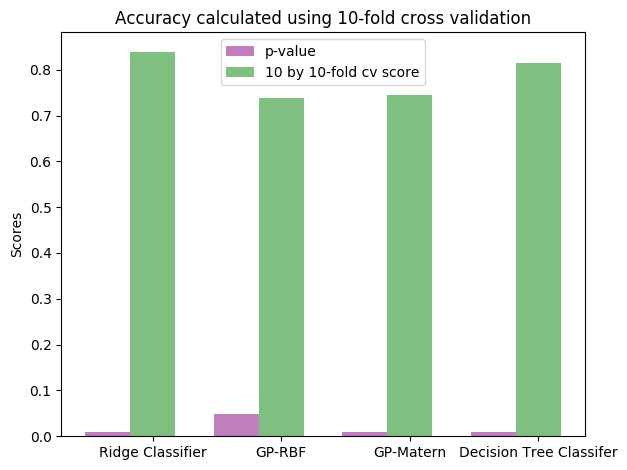

In [2]:
import matplotlib.pyplot as plt; plt.rcdefaults()

#objects = ('Ridge Classifier', 'GP-RBF', 'GP-Matern', 'Iris PCA', 'Iris no PCA')
objects = ('Ridge Classifier', 'GP-RBF', 'GP-Matern', 'Decision Tree Classifer')
y_pos = np.arange(len(objects))
#Iris p vals 0.009900990099009901, 0.009900990099009901
p_value = [0.009900990099009901, 0.04950495049504951, 0.009900990099009901, 0.009900990099009901]
ten_by_ten_fold_score = [0.8395381823613324, 0.7383874287428742, 0.745, 0.8145686940266158]
plt.bar(y_pos, p_value, 0.35, alpha=0.5, color='purple', label='p-value')
plt.bar(y_pos + 0.35, ten_by_ten_fold_score, 0.35, alpha=0.5, color='g', label='10 by 10-fold cv score')
plt.ylabel('Scores')
plt.title('Accuracy calculated using 10-fold cross validation')
plt.xticks(y_pos + 0.35, objects)
plt.tight_layout()
plt.legend()
plt.show()

In [4]:
train_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
test_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [4]:
AllData = train_df.append(test_df)

In [5]:
AllData.shape

(48842, 15)

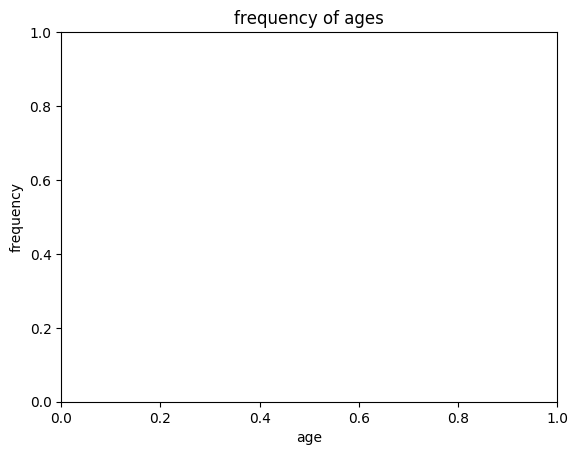

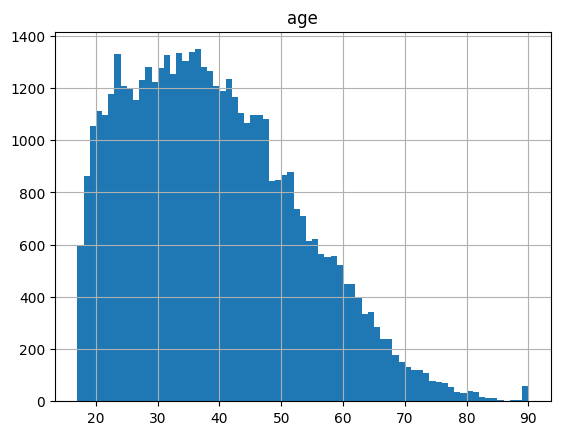

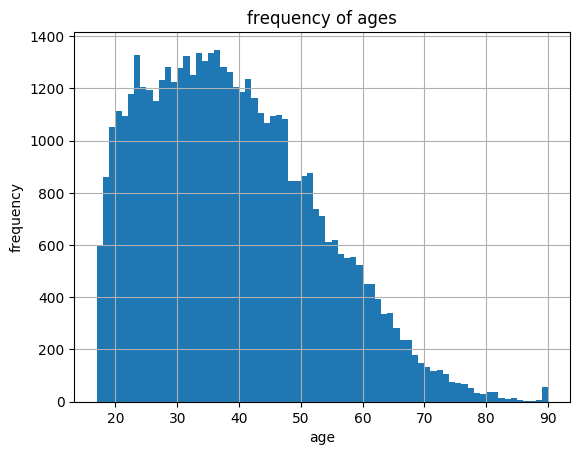

In [50]:
AllData.hist(column='age', bins=73)
plt.title('frequency of ages')
plt.xlabel('age')
plt.ylabel('frequency')
plt.show()

In [13]:
eduSeries = AllData['education'].value_counts()
eduSeries

 HS-grad         15784
 Some-college    10878
 Bachelors        8025
 Masters          2657
 Assoc-voc        2061
 11th             1812
 Assoc-acdm       1601
 10th             1389
 7th-8th           955
 Prof-school       834
 9th               756
 12th              657
 Doctorate         594
 5th-6th           509
 1st-4th           247
 Preschool          83
Name: education, dtype: int64

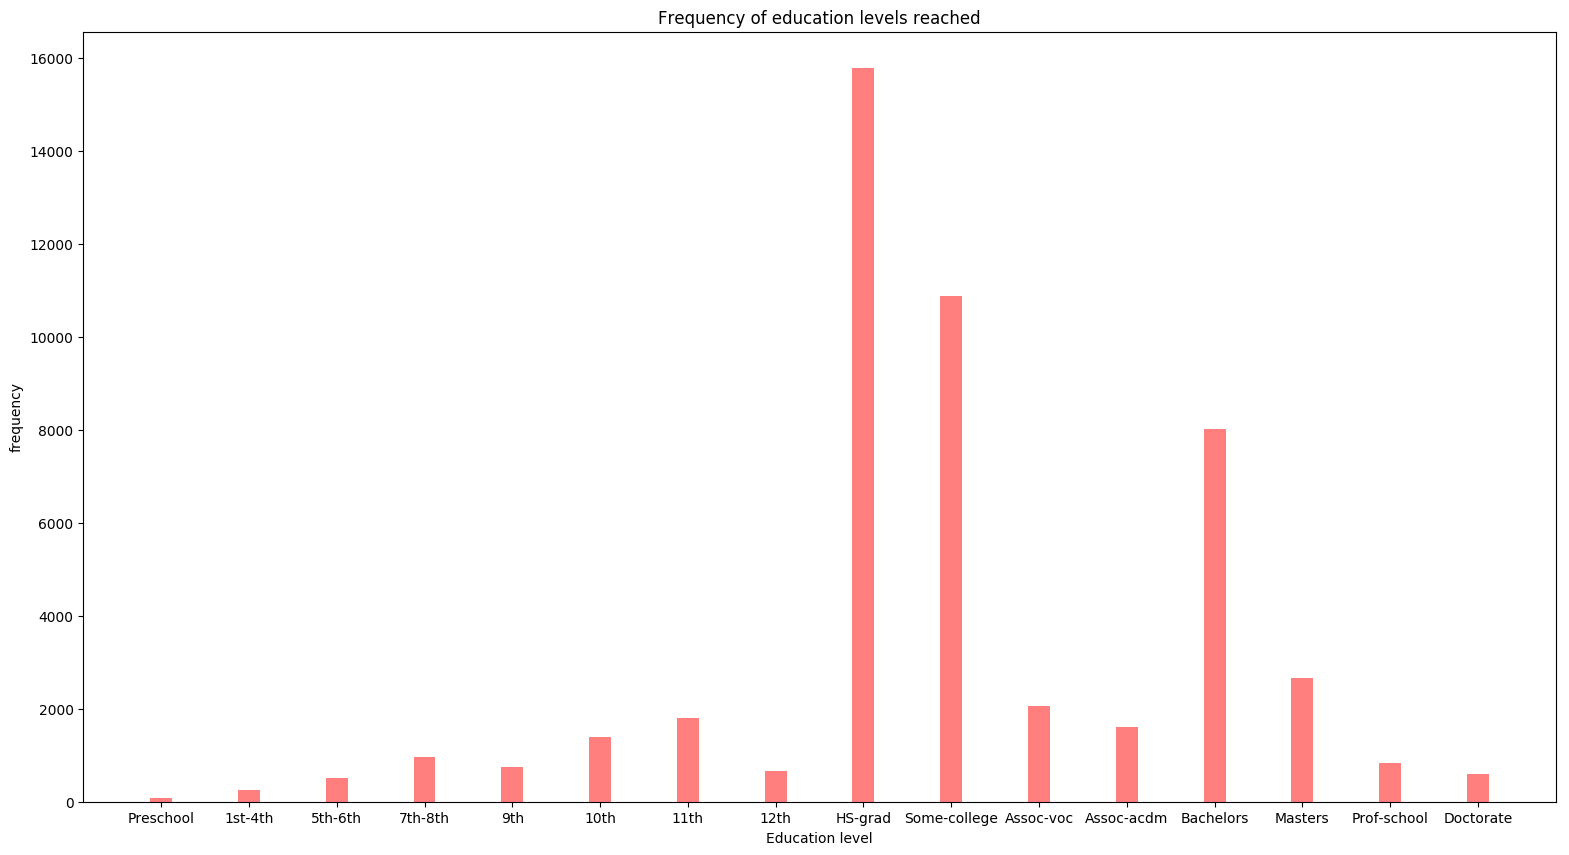

In [77]:
educationLevels = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate']
y_pos = np.arange(len(educationLevels))
freq = [83, 247, 509, 955, 756, 1389, 1812, 657, 15784, 10878, 2061, 1601, 8025, 2657, 834, 594]
plt.figure(figsize=(19, 10))
plt.bar(y_pos, freq, width=0.25, alpha=0.5, color='r', label='frequency of education level')
plt.title('Frequency of education levels reached')
plt.xlabel('Education level')
plt.ylabel('frequency')
plt.xticks(y_pos, educationLevels)
plt.show()

In [78]:
maritalStatus = AllData['marital-status'].value_counts()
maritalStatus

 Married-civ-spouse       22379
 Never-married            16117
 Divorced                  6633
 Separated                 1530
 Widowed                   1518
 Married-spouse-absent      628
 Married-AF-spouse           37
Name: marital-status, dtype: int64

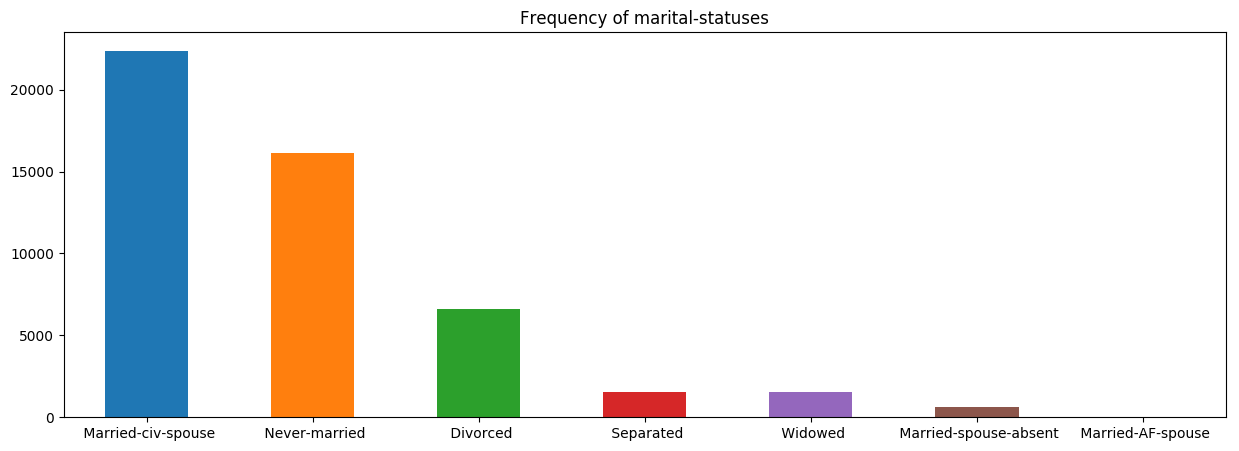

In [94]:
plt.figure(figsize=(15, 5))
maritalStatus.plot(kind='bar', rot=0)
plt.title('Frequency of marital-statuses')
plt.show()

In [95]:
occupation = AllData['occupation'].value_counts()
occupation

 Prof-specialty       6172
 Craft-repair         6112
 Exec-managerial      6086
 Adm-clerical         5611
 Sales                5504
 Other-service        4923
 Machine-op-inspct    3022
 ?                    2809
 Transport-moving     2355
 Handlers-cleaners    2072
 Farming-fishing      1490
 Tech-support         1446
 Protective-serv       983
 Priv-house-serv       242
 Armed-Forces           15
Name: occupation, dtype: int64

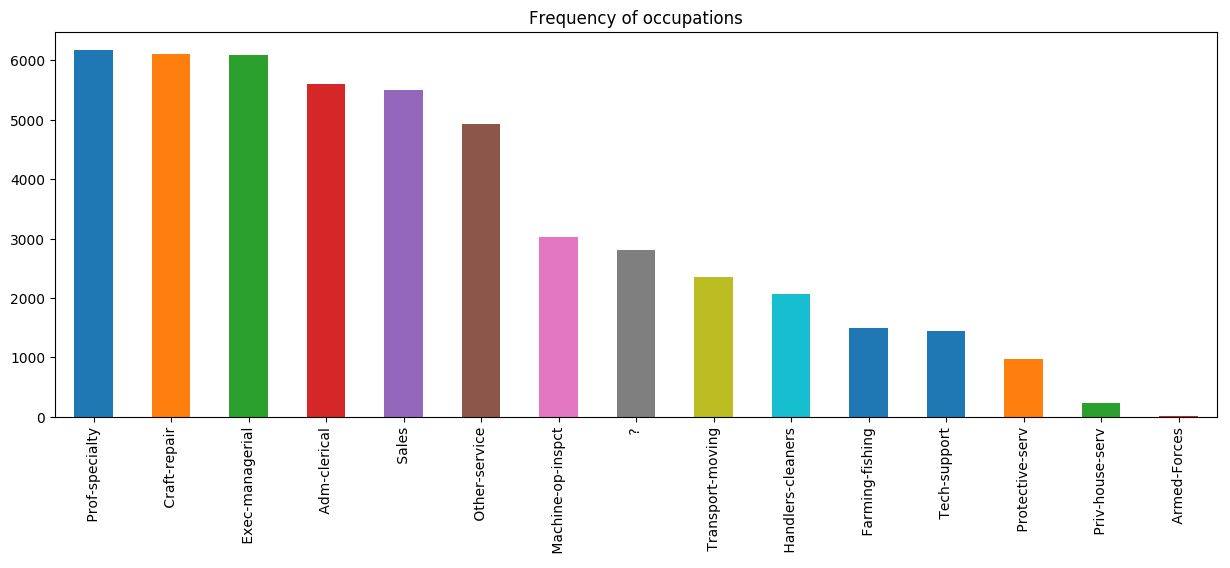

In [99]:
plt.figure(figsize=(15, 5))
occupation.plot(kind='bar')
plt.title('Frequency of occupations')
plt.show()

In [100]:
race = AllData['race'].value_counts()
race

 White                 41762
 Black                  4685
 Asian-Pac-Islander     1519
 Amer-Indian-Eskimo      470
 Other                   406
Name: race, dtype: int64

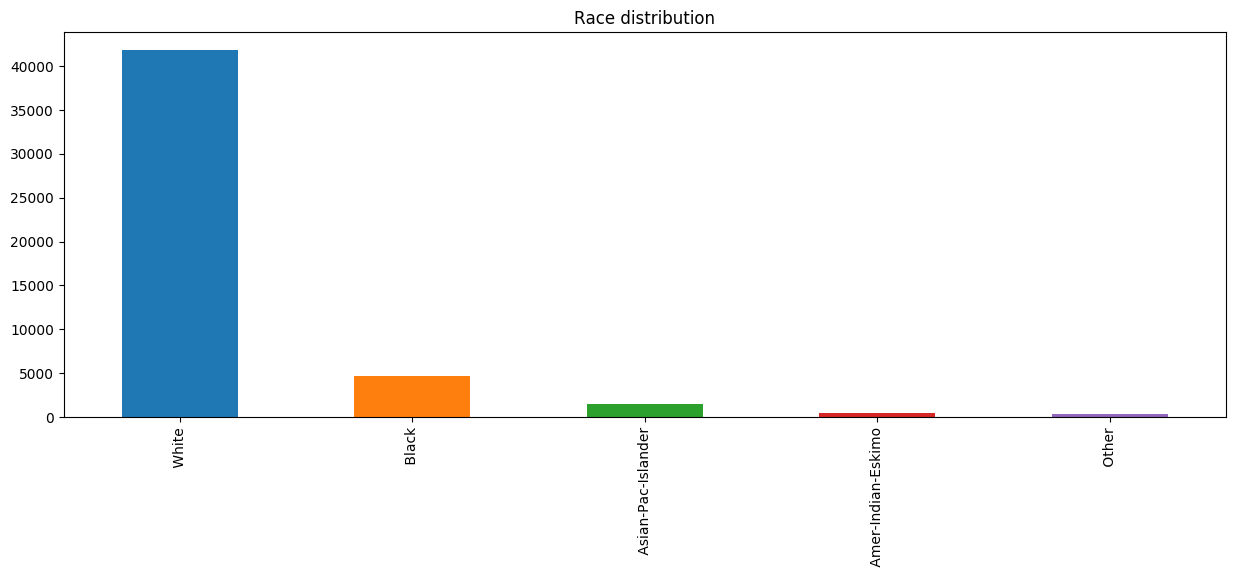

In [104]:
plt.figure(figsize=(15, 5))
race.plot(kind='bar')
plt.title('Race distribution')
plt.show()

In [102]:
sex = AllData['sex'].value_counts()
sex

 Male      32650
 Female    16192
Name: sex, dtype: int64

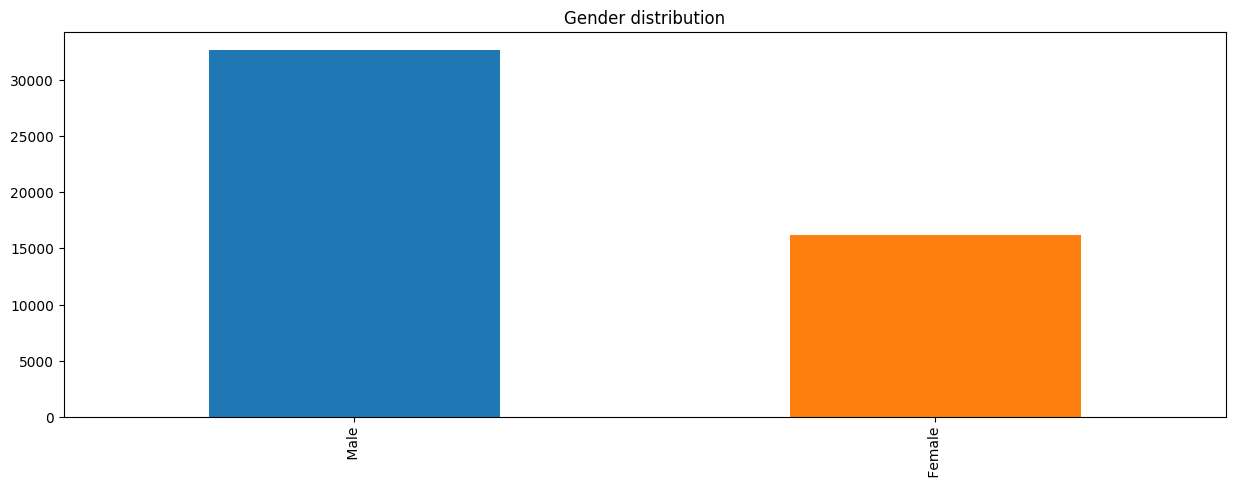

In [105]:
plt.figure(figsize=(15, 5))
sex.plot(kind='bar')
plt.title('Gender distribution')
plt.show()

In [183]:
native_country = AllData['native-country'].value_counts()
native_country

 United-States                 43832
 Mexico                          951
 ?                               857
 Philippines                     295
 Germany                         206
 Puerto-Rico                     184
 Canada                          182
 El-Salvador                     155
 India                           151
 Cuba                            138
 England                         127
 China                           122
 South                           115
 Jamaica                         106
 Italy                           105
 Dominican-Republic              103
 Japan                            92
 Guatemala                        88
 Poland                           87
 Vietnam                          86
 Columbia                         85
 Haiti                            75
 Portugal                         67
 Taiwan                           65
 Iran                             59
 Greece                           49
 Nicaragua                        49
 

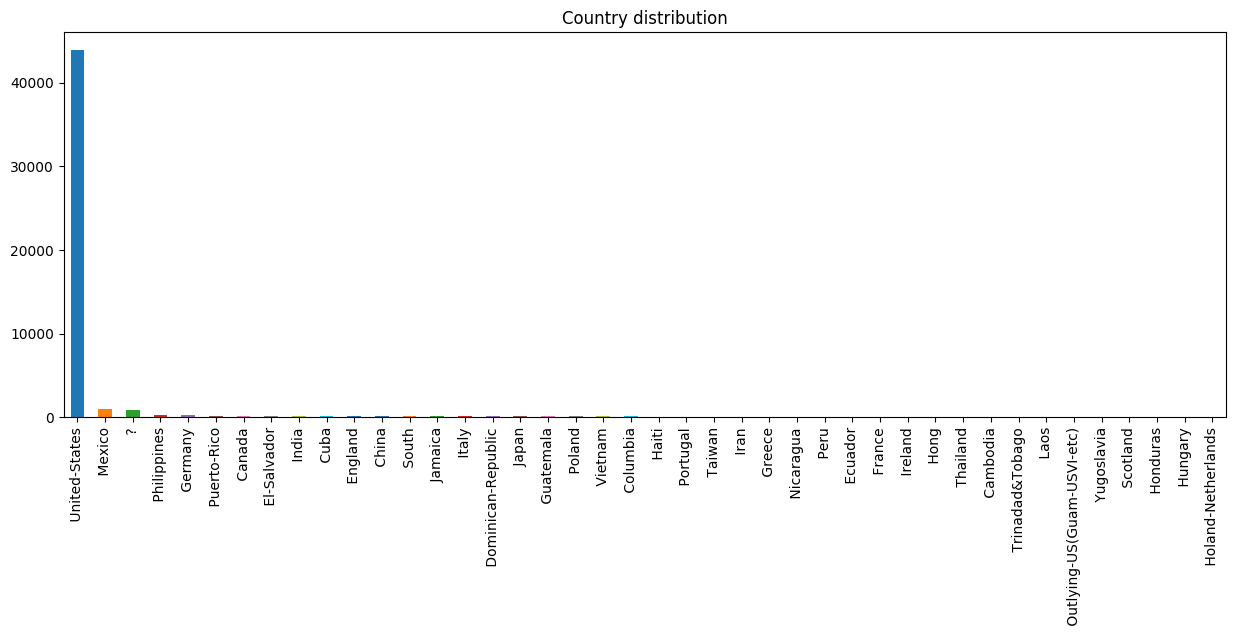

In [185]:
plt.figure(figsize=(15, 5))
native_country.plot(kind='bar')
plt.title('Country distribution')
plt.show()

In [186]:
amountOfMoney = AllData['class'].value_counts()
amountOfMoney

 <=50K     24720
 <=50K.    12435
 >50K       7841
 >50K.      3846
Name: class, dtype: int64

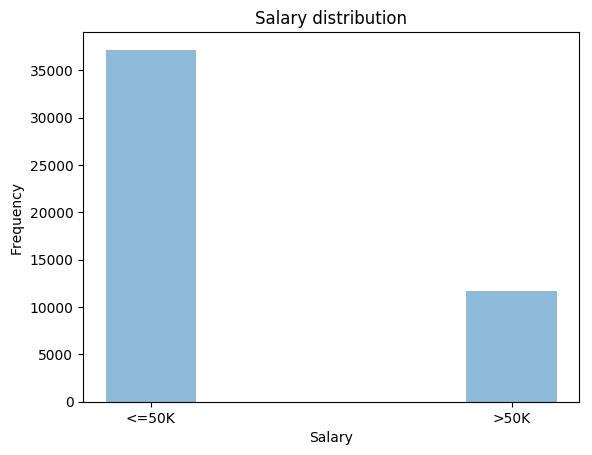

In [194]:
salary = ['<=50K', '>50K']
y_pos = np.arange(len(salary))
freq = [24720+12435, 7841+3846]
plt.bar(y_pos, freq, width=0.25, alpha=0.5)
plt.title('Salary distribution')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.xticks(y_pos, salary)
plt.show()

In [ ]:
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(train_df, hue="species")